# Debugging Factor Analysis Implementation

This notebook investigates the Factor Analysis implementation step by step, focusing on:
1. Data generation
2. E-step computation
3. M-step updates
4. Full model fitting

In [1]:
%matplotlib inline
import numpy as np
try:
    from sklearn.decomposition import FactorAnalysis as sklearn_fa
except:
    !pip install scikit-learn
    from sklearn.decomposition import FactorAnalysis as sklearn_fa
try:
    import procrustes
except:
    !pip install qc-procrustes
    import procrustes

In [2]:
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import seaborn as sns 
import equinox as eqx
from jax import config
from sppcax.models import PPCA, PFA
from sppcax.distributions import MultivariateNormal, MultivariateNormalGamma
from sppcax.models import fit, transform, inverse_transform
from sppcax.models.factor_analysis_algorithms import _to_distribution

# For better visualization
sns.set_theme('notebook', style='dark', palette="deep")
config.update("jax_enable_x64", True)

## 1. Data Generation

First, let's generate synthetic data with known structure:

Data shapes:
X: (100, 10)
Z_true: (100, 3)
W_true: (3, 10)


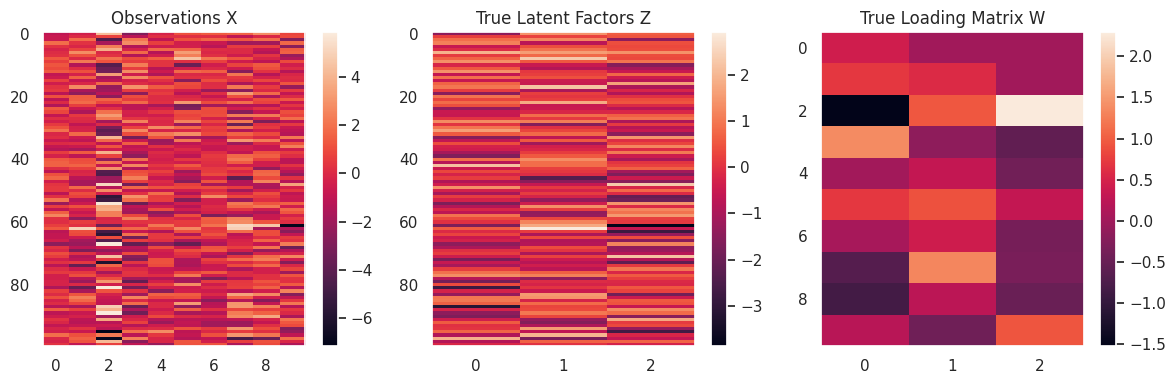

In [3]:
# Set random seed for reproducibility
key = jr.PRNGKey(0)

# Data dimensions
n_samples = 100
n_features = 10
n_components = 3

assert (n_features - n_components)**2 >= n_features + n_components

mask = jnp.transpose(jnp.clip(jnp.arange(n_features), a_max=n_components)[..., None] >= jnp.arange(n_components))

# Generate true latent factors
key, subkey = jr.split(key)
Z_true = jr.normal(subkey, (n_samples, n_components))

# Generate true loading matrix with some features being noise
key, subkey = jr.split(key)
W_true = jr.normal(subkey, (n_components, n_features)) * mask

# Generate observations with noise
key, subkey = jr.split(key)
noise = jr.normal(subkey, (n_samples, n_features))
X = Z_true @ W_true + noise

X_dist = _to_distribution(X)

print("Data shapes:")
print(f"X: {X.shape}")
print(f"Z_true: {Z_true.shape}")
print(f"W_true: {W_true.shape}")

# Visualize the data
plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.imshow(X, aspect='auto')
plt.title('Observations X')
plt.colorbar()

plt.subplot(132)
plt.imshow(Z_true, aspect='auto')
plt.title('True Latent Factors Z')
plt.colorbar()

plt.subplot(133)
plt.imshow(W_true.T, aspect='auto')
plt.title('True Loading Matrix W')
plt.colorbar()

plt.tight_layout()

The Procrustes error for the loading matrix is 1.1376169935242693


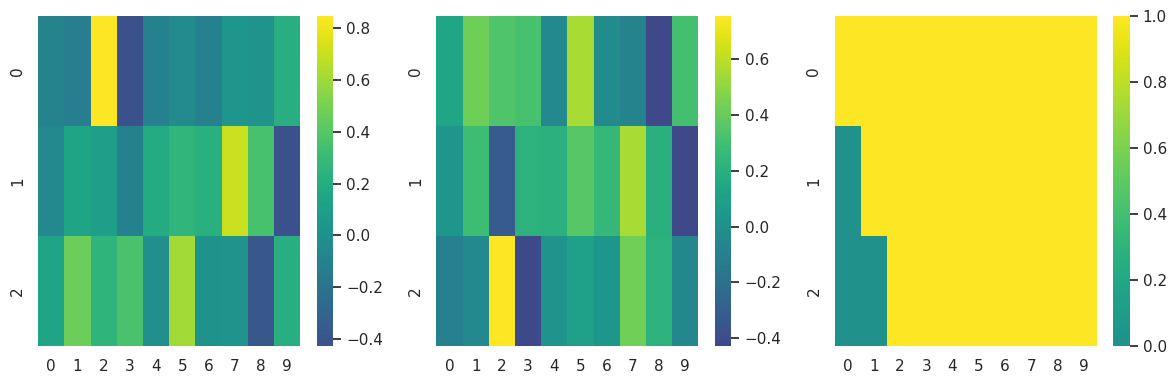

In [4]:
z_dim = n_components
u, s, v = jnp.linalg.svd(X - X.mean(0), full_matrices=False)
pca_w = v[:z_dim]

proc_trans = procrustes.orthogonal(np.asarray(pca_w.T), np.asarray(mask.T).astype(jnp.float32), scale=True)
print(f"The Procrustes error for the loading matrix is {proc_trans.error}")

# Heatmap of transformed loading matrix
pca_w_trans = proc_trans.t.T @ pca_w
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

sns.heatmap(pca_w, cmap='viridis', fmt = ".2f", center = 0, ax=axes[0])
sns.heatmap(pca_w_trans, cmap='viridis', fmt = ".2f", center = 0, ax=axes[1])
sns.heatmap(mask, cmap='viridis', fmt = ".2f", center = 0, ax=axes[2])
fig.tight_layout()

The Procrustes error for the loading matrix is 1.2900988160718834


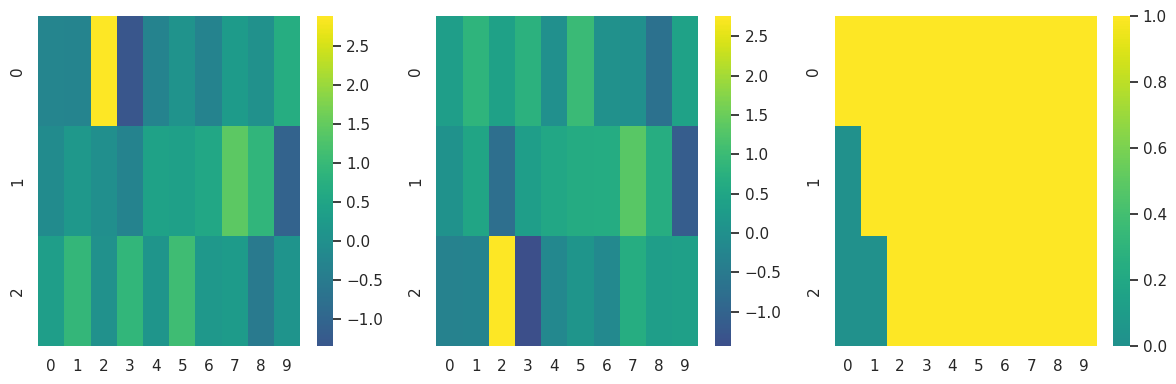

In [5]:
fa = sklearn_fa(n_components=z_dim, rotation='varimax')
res = fa.fit(X)

proc_trans = procrustes.orthogonal(np.asarray(res.components_.T), np.asarray(mask.T).astype(jnp.float32), scale=True)
print(f"The Procrustes error for the loading matrix is {proc_trans.error}")

# Heatmap of transformed loading matrix
fa_w_trans = proc_trans.t.T @ res.components_
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

sns.heatmap(res.components_, cmap='viridis', fmt = ".2f", center = 0, ax=axes[0])
sns.heatmap(fa_w_trans, cmap='viridis', fmt = ".2f", center = 0, ax=axes[1])
sns.heatmap(mask, cmap='viridis', fmt = ".2f", center = 0, ax=axes[2])
fig.tight_layout()

## 2. E-step Investigation

Let's initialize a model and examine each part of the E-step computation:

E-step computation:
Ez + Ezz shape: (100, 12)


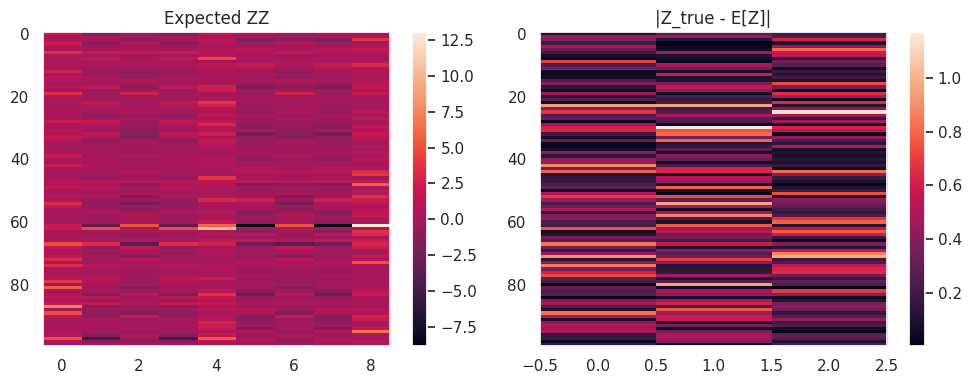

In [6]:
from sppcax.models import e_step

# Initialize model with known parameters
model = PPCA(n_components=n_components, n_features=n_features)

q_w_psi = MultivariateNormalGamma(
    loc=W_true.mT,  # Use true W for initialization
    scale_tril=jnp.eye(n_components)/100,
    mask=model.q_w_psi.mvn.mask,
    alpha0=model.q_w_psi.gamma.alpha,
    beta0=1.0,
    isotropic_noise=True
)

model = eqx.tree_at(lambda x: x.q_w_psi, model, q_w_psi)

# Step through E-step computation
print("E-step computation:")

# Compute expectations
qz = e_step(model, X_dist)
exp_stats = qz.expected_sufficient_statistics
print(f"Ez + Ezz shape: {exp_stats.shape}")

# Visualize E-step results
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.imshow(exp_stats[:, n_components:], aspect='auto')
plt.title('Expected ZZ')
plt.colorbar()

plt.subplot(122)
plt.imshow(jnp.abs(Z_true - Z_true.mean(0) - qz.mean), aspect='auto')
plt.title('|Z_true - E[Z]|')
plt.colorbar()

plt.tight_layout()
plt.show()

E-step computation:
Ez + Ezz shape: (100, 12)


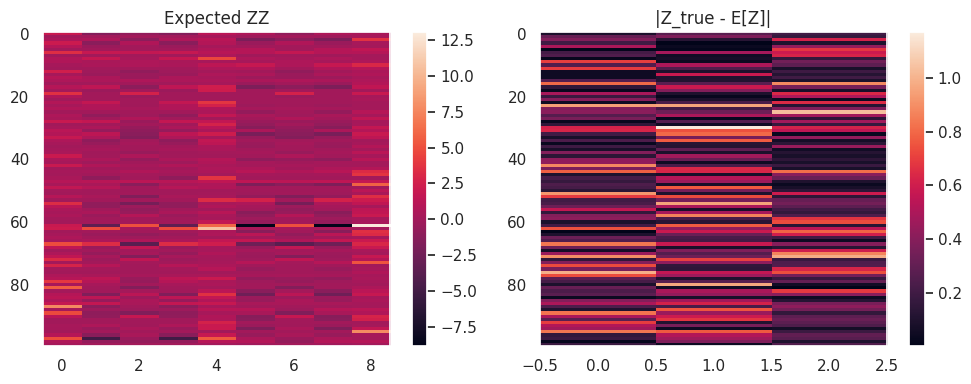

In [7]:
from sppcax.models import e_step

# Initialize model with known parameters
model = PPCA(n_components=n_components, n_features=n_features, bmr_e_step=True, use_bias=False)

q_w_psi = MultivariateNormalGamma(
    loc=W_true.mT,  # Use true W for initialization
    scale_tril=jnp.eye(n_components)/100,
    mask=model.q_w_psi.mvn.mask,
    alpha0=model.q_w_psi.gamma.alpha,
    beta0=1.0,
    isotropic_noise=True
)

model = eqx.tree_at(lambda x: x.q_w_psi, model, q_w_psi)

# Step through E-step computation
print("E-step computation:")

# Compute expectations
key, _key = jr.split(key)
qz = e_step(model, X_dist, use_bmr=True, key=_key)
exp_stats = qz.expected_sufficient_statistics
print(f"Ez + Ezz shape: {exp_stats.shape}")

# Visualize E-step results
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.imshow(exp_stats[:, n_components:], aspect='auto')
plt.title('Expected ZZ')
plt.colorbar()

plt.subplot(122)
plt.imshow(jnp.abs(Z_true - Z_true.mean(0) - qz.mean), aspect='auto')
plt.title('|Z_true - E[Z]|')
plt.colorbar()

plt.tight_layout()
plt.show()

## 3. M-step Investigation

Now let's examine the M-step updates:

M-step computation:


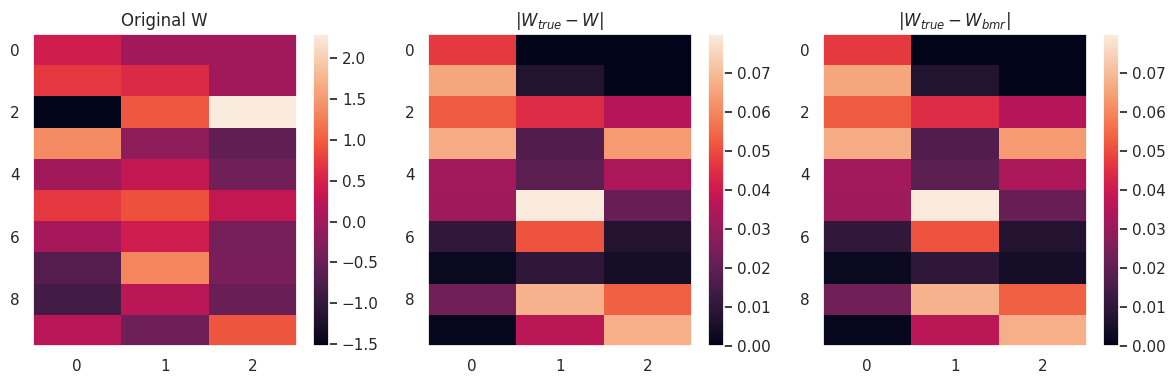

noise precision 1.2501699929242591 1.2519910996072412
expected tau [1.18044468 1.55491139 0.87212739] [1.16139311 1.47316385 0.88469723]


In [8]:
from sppcax.models import m_step

# Step through M-step computation
print("M-step computation:")

# 4. Update model
with jax.disable_jit(disable=True):
    updated_model = m_step(model, X_dist, qz, use_bmr_opt=False)
    updated_model2 = m_step(model, X_dist, qz, use_bmr_opt=True)

# Visualize M-step results
plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.imshow(model.q_w_psi.mean, aspect='auto')
plt.title('Original W')
plt.colorbar()

plt.subplot(132)
plt.imshow(jnp.abs(W_true.mT - updated_model.q_w_psi.mean), aspect='auto')
plt.title(r'$|W_{true} - W|$')
plt.colorbar()

plt.subplot(133)
plt.imshow(jnp.abs(W_true.mT - updated_model2.q_w_psi.mean), aspect='auto')
plt.title(r'$|W_{true} - W_{bmr}|$')
plt.colorbar()

plt.tight_layout()
plt.show()

print('noise precision', updated_model2.q_w_psi.gamma.mean, updated_model.q_w_psi.gamma.mean)
print('expected tau', updated_model2.q_tau.mean, updated_model.q_tau.mean)

## 4. Full Model Fitting

Let's test the complete fitting procedure:

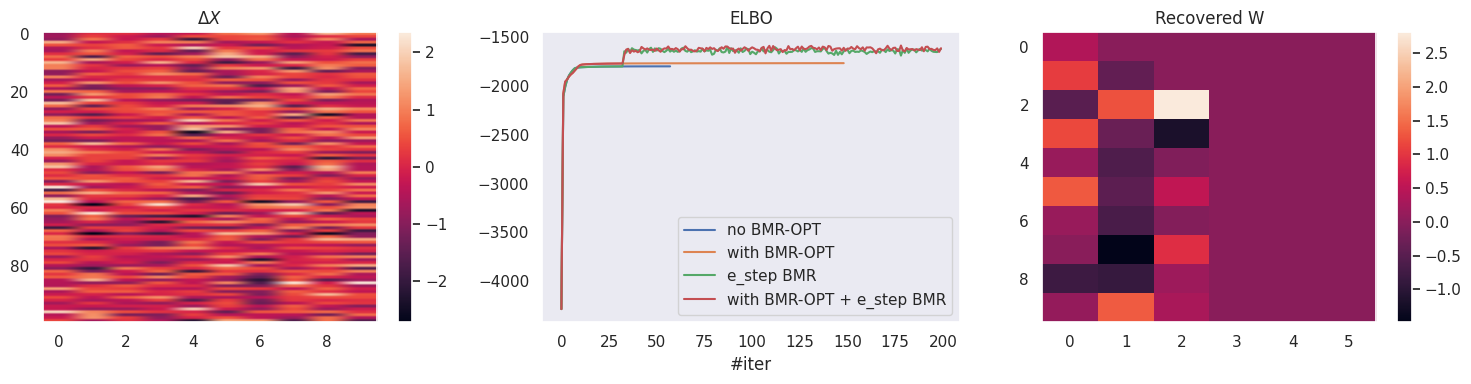

Reconstruction error: 0.687142
ARD posterior [1.67995597e+00 1.08576082e+00 6.91911915e-01 6.34008826e+02
 7.91629836e+02 7.32188841e+02]
Posterior noise precision 1.0828268348945422


In [9]:
# Test probabilistic Principle Component Analysis
# Initialize model
model1 = PPCA(n_components=2*n_components, n_features=n_features, optimize_with_bmr=False)
model2 = PPCA(n_components=2*n_components, n_features=n_features, optimize_with_bmr=True)
model3 = PPCA(n_components=2*n_components, n_features=n_features, bmr_e_step=True)
model4 = PPCA(n_components=2*n_components, n_features=n_features, optimize_with_bmr=True, bmr_e_step=True)

# Fit model
key, _key = jr.split(key)
fitted_model1, elbos1 = fit(model1, X, _key, tol=1e-2, n_iter=200)

key, _key = jr.split(key)
fitted_model2, elbos2 = fit(model2, X, _key, tol=1e-2, n_iter=200)

key, _key = jr.split(key)
fitted_model3, elbos3 = fit(model3, X, _key, tol=1e-2, n_iter=200)

key, _key = jr.split(key)
fitted_model4, elbos4 = fit(model4, X, _key, tol=1e-2, n_iter=200)

m = jnp.argmax(jnp.array([elbos1[-1], elbos2[-1], elbos3[-1], elbos4[-1]])).item()
f_model = [fitted_model1, fitted_model2, fitted_model3, fitted_model4][m]

# Transform data
qz = transform(f_model, X)

# inverse transform returns a multivariate normal distribution
X_reconstructed = inverse_transform(f_model, qz).mean

# Visualize results
plt.figure(figsize=(15, 4))

plt.subplot(131)
plt.imshow(X - X_reconstructed, aspect='auto')
plt.title(r'$\Delta X$')
plt.colorbar()

plt.subplot(132)
plt.plot(elbos1, label='no BMR-OPT')
plt.plot(elbos2, label='with BMR-OPT')
plt.plot(elbos3, label='e_step BMR')
plt.plot(elbos4, label='with BMR-OPT + e_step BMR')
plt.title('ELBO')
plt.xlabel('#iter')
plt.legend()

plt.subplot(133)
plt.imshow(f_model.q_w_psi.mean, aspect='auto')
plt.title('Recovered W')
plt.colorbar()

plt.tight_layout()
plt.show()

# Print reconstruction error
error = jnp.mean((X - X_reconstructed) ** 2)
print(f"Reconstruction error: {error:.6f}")

print("ARD posterior", f_model.q_tau.mean)
print("Posterior noise precision", f_model.q_w_psi.gamma.mean)

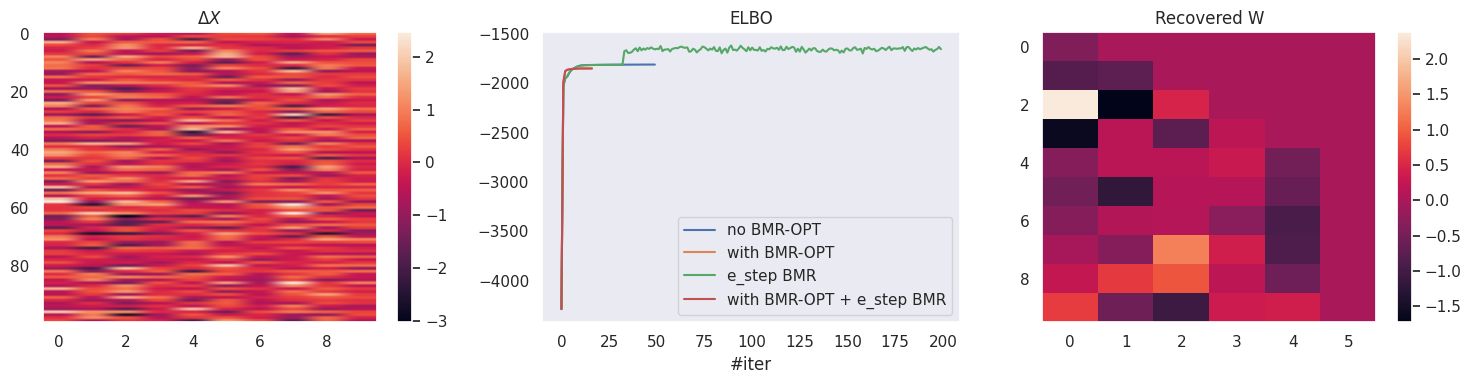

Reconstruction error: 0.608294
ARD posterior [1.08885368 1.76487946 1.45302882 4.25474707 1.37039561 4.75836619]
Posterior noise precision [1.24872216 1.05418254 0.45437486 1.55271797 1.32783829 0.93933482
 2.4075995  0.70464521 1.29347601 1.50989145]


In [10]:
# Test probabilistic Factor Analysis
# Initialize model
model1 = PFA(n_components=2*n_components, n_features=n_features)
model2 = PFA(n_components=2*n_components, n_features=n_features, optimize_with_bmr=True)
model3 = PFA(n_components=2*n_components, n_features=n_features, bmr_e_step=True)
model4 = PFA(
    n_components=2*n_components, n_features=n_features, optimize_with_bmr=True, bmr_e_step=True
)


# Fit model
key, _key = jr.split(key)
fitted_model1, elbos1 = fit(model1, X, _key, tol=1e-2, n_iter=200)

key, _key = jr.split(key)
fitted_model2, elbos2 = fit(model2, X, _key, tol=1e-2, n_iter=200)

key, _key = jr.split(key)
fitted_model3, elbos3 = fit(model3, X, _key, tol=1e-2, n_iter=200)

key, _key = jr.split(key)
fitted_model4, elbos4 = fit(model4, X, _key, tol=1e-2, n_iter=200)

m = jnp.argmax(jnp.array([elbos1[-1], elbos2[-1], elbos3[-1], elbos4[-1]])).item()
f_model = [fitted_model1, fitted_model2, fitted_model3, fitted_model4][m]  

# Transform data
qz = transform(f_model, X)

# inverse transform returns a multivariate normal distribution
X_reconstructed = inverse_transform(f_model, qz).mean

# Visualize results
plt.figure(figsize=(15, 4))

plt.subplot(131)
plt.imshow(X - X_reconstructed, aspect='auto')
plt.title(r'$\Delta X$')
plt.colorbar()

plt.subplot(132)
plt.plot(elbos1, label='no BMR-OPT')
plt.plot(elbos2, label='with BMR-OPT')
plt.plot(elbos3, label='e_step BMR')
plt.plot(elbos4, label='with BMR-OPT + e_step BMR')
plt.title('ELBO')
plt.xlabel('#iter')
plt.legend()

plt.subplot(133)
plt.imshow(f_model.q_w_psi.mvn.mean, aspect='auto')
plt.title('Recovered W')
plt.colorbar()

plt.tight_layout()
plt.show()

# Print reconstruction error
error = jnp.mean((X - X_reconstructed) ** 2)
print(f"Reconstruction error: {error:.6f}")

print("ARD posterior", f_model.q_tau.mean)
print("Posterior noise precision", f_model.q_w_psi.gamma.mean)

## 5. Working with missing data

We illustrate here how to mask missing data.

[Array(-1523.02901034, dtype=float64), Array(-1493.76614129, dtype=float64), Array(-1358.63648669, dtype=float64), Array(-1493.76614129, dtype=float64)]


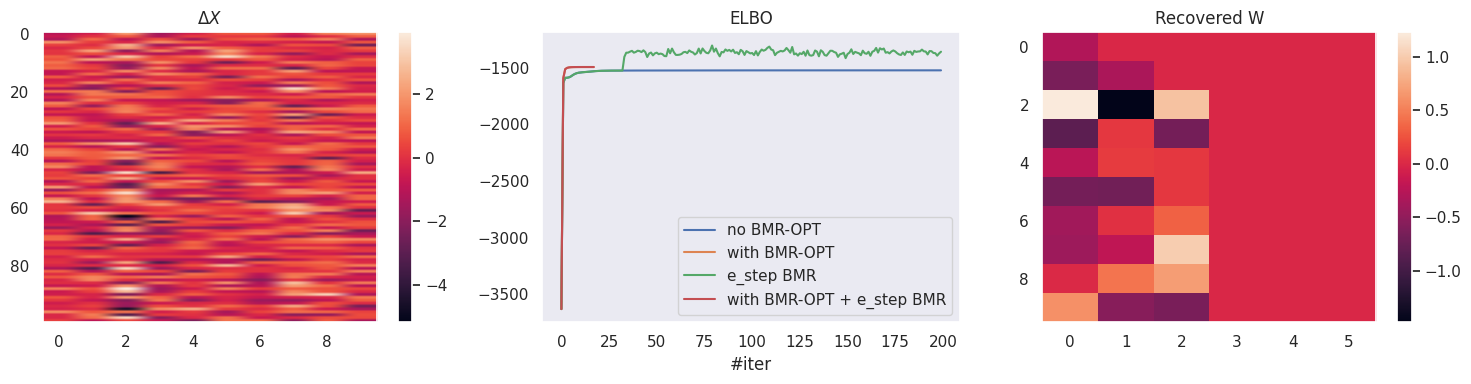

Reconstruction error: 1.428365
ARD posterior [3.48524461 4.21602768 3.12920453 7.10730746 6.05817131 5.58978961]
Posterior noise precision [1.33306133 0.7213486  0.20927192 0.62047765 1.31125087 0.6177352
 1.31873912 0.43653472 0.84227031 0.76636252]


In [11]:
# mask 20% of the observed features
key, _key = jr.split(key)
data_mask = jr.bernoulli(_key, p=.8, shape=X.shape)

# Initialize model
model1 = PFA(n_components=2 * n_components, n_features=n_features, data_mask=data_mask)
model2 = PFA(n_components=2 * n_components, n_features=n_features, data_mask=data_mask, optimize_with_bmr=True)
model3 = PFA(n_components=2 * n_components, n_features=n_features, data_mask=data_mask, bmr_e_step=True)
model4 = PFA(n_components=2*n_components, n_features=n_features, data_mask=data_mask, optimize_with_bmr=True, bmr_e_step=True)

# Fit model
key, _key = jr.split(key)
fitted_model1, elbos1 = fit(model1, X, _key, tol=1e-3, n_iter=200)

key, _key = jr.split(key)
fitted_model2, elbos2 = fit(model2, X, _key, tol=1e-3, n_iter=200)

key, _key = jr.split(key)
fitted_model3, elbos3 = fit(model3, X, _key, tol=1e-3, n_iter=200)

key, _key = jr.split(key)
fitted_model4, elbos4 = fit(model4, X, _key, tol=1e-3, n_iter=200)

print([elbos1[-1], elbos2[-1], elbos3[-1], elbos4[-1]])
m = jnp.argmax(jnp.array([elbos1[-1], elbos2[-1], elbos3[-1], elbos4[-1]])).item()
f_model = [fitted_model1, fitted_model2, fitted_model3, fitted_model4][m]  

# Transform data
use_bmr = True if m > 1 else False
key, _key = jr.split(key)
qz = transform(f_model, X, use_data_mask=True, use_bmr=use_bmr, key=_key)

# inverse transform returns a multivariate normal distribution
X_reconstructed = inverse_transform(f_model, qz).mean

# Visualize results
plt.figure(figsize=(15, 4))

plt.subplot(131)
plt.imshow((X - X_reconstructed) , aspect='auto')
plt.title(r'$\Delta X$')
plt.colorbar()

plt.subplot(132)
plt.plot(elbos1, label='no BMR-OPT')
plt.plot(elbos2, label='with BMR-OPT')
plt.plot(elbos3, label='e_step BMR')
plt.plot(elbos4, label='with BMR-OPT + e_step BMR')
plt.title('ELBO')
plt.xlabel('#iter')
plt.legend()

plt.subplot(133)
plt.imshow(f_model.q_w_psi.mvn.mean, aspect='auto')
plt.title('Recovered W')
plt.colorbar()

plt.tight_layout()
plt.show()

# Print reconstruction error
error = jnp.mean(jnp.square((X - X_reconstructed)))
print(f"Reconstruction error: {error:.6f}")

print("ARD posterior", f_model.q_tau.mean)
print("Posterior noise precision", f_model.q_w_psi.gamma.mean)

## 6. Passing uncertain measurements

Here, we illustrate here how to pass data with uncertainty associated with measurements.

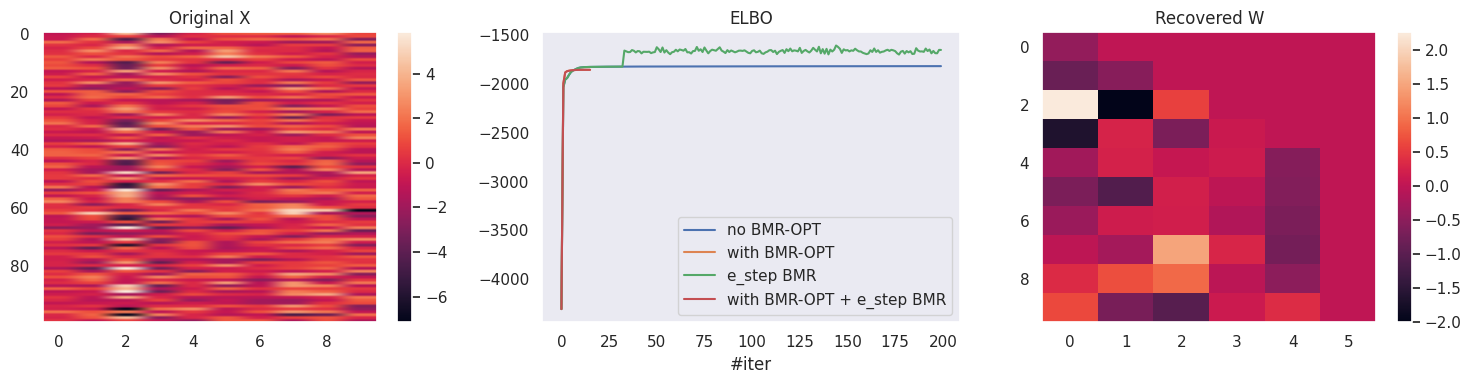

Reconstruction error: 0.827887
ARD posterior [1.15872525 1.71486373 1.53123134 5.7654959  2.05841647 5.32181638]
Posterior noise precision [1.25242729 0.87597132 0.46224639 1.36894444 1.32448961 0.99142638
 1.62551371 0.71985917 1.21583385 1.13377529]


In [12]:
# add uncertainty to observations
X_dist = MultivariateNormal(loc=X, precision=50*jnp.eye(n_features))

# Initialize model
model1 = PFA(n_components=2 * n_components, n_features=n_features)
model2 = PFA(n_components=2 * n_components, n_features=n_features, optimize_with_bmr=True)
model3 = PFA(n_components=2 * n_components, n_features=n_features, bmr_e_step=True)
model4 = PFA(n_components=2 * n_components, n_features=n_features, optimize_with_bmr=True, bmr_e_step=True)


# Fit model
key, _key = jr.split(key)
fitted_model1, elbos1 = fit(model1, X_dist, _key, tol=1e-2, n_iter=200)

key, _key = jr.split(key)
fitted_model2, elbos2 = fit(model2, X_dist, _key, tol=1e-2, n_iter=200)

key, _key = jr.split(key)
fitted_model3, elbos3 = fit(model3, X_dist, _key, tol=1e-2, n_iter=200)

key, _key = jr.split(key)
fitted_model4, elbos4 = fit(model4, X_dist, _key, tol=1e-2, n_iter=200)

m = jnp.argmax(jnp.array([elbos1[-1], elbos2[-1], elbos3[-1], elbos4[-1]])).item()
f_model = [fitted_model1, fitted_model2, fitted_model3, fitted_model4][m]  

# Transform data
use_bmr = True if m > 1 else False
key, _key = jr.split(key)
qz = transform(f_model, X_dist, use_bmr=use_bmr, key=_key)

# inverse transform returns a multivariate normal distribution
X_reconstructed = inverse_transform(f_model, qz).mean

# Visualize results
plt.figure(figsize=(15, 4))

plt.subplot(131)
plt.imshow(X, aspect='auto')
plt.title('Original X')
plt.colorbar()

plt.subplot(132)
plt.plot(elbos1, label='no BMR-OPT')
plt.plot(elbos2, label='with BMR-OPT')
plt.plot(elbos3, label='e_step BMR')
plt.plot(elbos4, label='with BMR-OPT + e_step BMR')
plt.title('ELBO')
plt.xlabel('#iter')
plt.legend()

plt.subplot(133)
plt.imshow(f_model.q_w_psi.mean, aspect='auto')
plt.title('Recovered W')
plt.colorbar()

plt.tight_layout()
plt.show()

# Print reconstruction error
error = jnp.mean((X - X_reconstructed) ** 2)
print(f"Reconstruction error: {error:.6f}")

print("ARD posterior", f_model.q_tau.mean)
print("Posterior noise precision", f_model.q_w_psi.gamma.mean)

## 7. Model pruning with Bayesian model reduction

Here, we illustrate the pruning of the parameters of the loading matrix with BMR. We will
compare variants with and without BMR based optimisation of $q(\pmb{\tau})$ and $q(\pmb{\psi})$ during the VBM step, and with BMR pruning of $q(z)$ during the VBE step. 

[0.91666667 0.58333333 0.75       0.08333333 0.25       0.08333333]
[0.5 0.5 0.5 0.5 0.5 0.5]
[0.75       0.5        0.66666667 0.08333333 0.25       0.08333333]
[0.5 0.5 0.5 0.5 0.5 0.5]


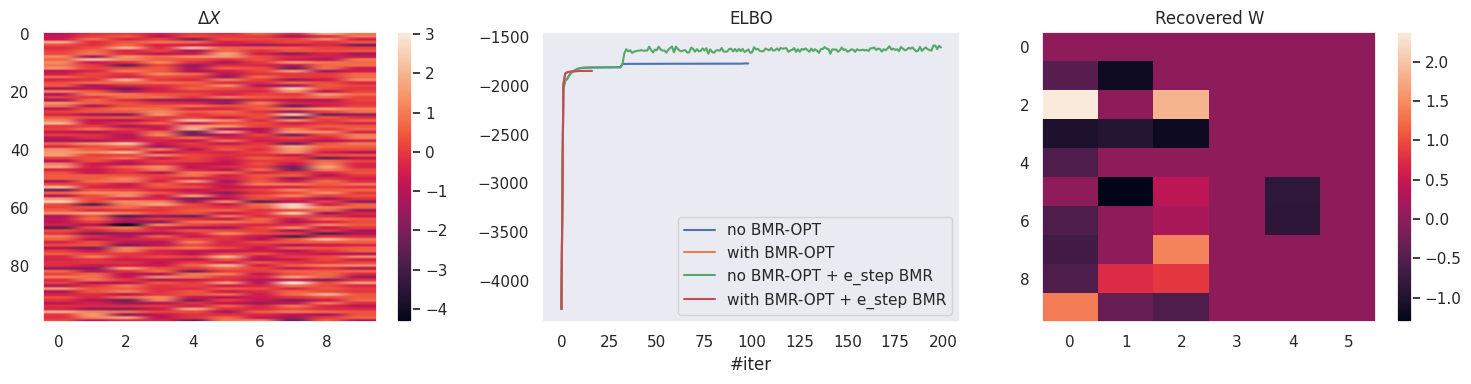

Reconstruction error: 0.838074
ARD posterior [0.90643426 0.99219599 1.08016327 1.         0.91679455 1.        ]
Posterior noise precision [1.06222557 1.1067912  0.55154041 1.33700372 1.09473745 0.93730921
 2.08774872 0.59345989 0.99605732 1.38335277]


In [13]:
# Initialize model - note that BMR pruning requires random state as it uses Gibbs sampling for prining
model1 = PFA(n_components=2 * n_components, n_features=n_features, bmr_m_step=True)
model2 = PFA(n_components=2 * n_components, n_features=n_features, optimize_with_bmr=True, bmr_m_step=True)
model3 = PFA(n_components=2 * n_components, n_features=n_features, bmr_e_step=True, bmr_m_step=True, bmr_e_step_opts=('max_iter', 4, 'pi', 0.5))
model4 = PFA(n_components=2 * n_components, n_features=n_features, optimize_with_bmr=True, bmr_e_step=True, bmr_m_step=True, bmr_e_step_opts=('max_iter', 4, 'pi', 0.5))


# Fit model
key, _key = jr.split(key)
fitted_model1, elbos1 = fit(model1, X, _key, tol=1e-2, n_iter=200, bmr_frequency=32)
print(fitted_model1.sparsity_prior.mean)

key, _key = jr.split(key)
fitted_model2, elbos2 = fit(model2, X, _key, tol=1e-2, n_iter=200, bmr_frequency=32)
print(fitted_model2.sparsity_prior.mean)

key, _key = jr.split(key)
fitted_model3, elbos3 = fit(model3, X, _key, tol=1e-2, n_iter=200, bmr_frequency=32)
print(fitted_model3.sparsity_prior.mean)

key, _key = jr.split(key)
fitted_model4, elbos4 = fit(model4, X, _key, tol=1e-2, n_iter=200, bmr_frequency=32)
print(fitted_model4.sparsity_prior.mean)

m = jnp.argmax(jnp.array([elbos1[-1], elbos2[-1], elbos3[-1], elbos4[-1]])).item()
f_model = [fitted_model1, fitted_model2, fitted_model3, fitted_model4][m]

# Transform data
key, _key = jr.split(key)
qz = transform(f_model, X, use_bmr=True, key=_key)

# inverse transform returns a multivariate normal distribution
X_reconstructed = inverse_transform(f_model, qz).mean

# Visualize results
plt.figure(figsize=(15, 4))

plt.subplot(131)
plt.imshow(X - X_reconstructed, aspect='auto')
plt.title(r'$\Delta X$')
plt.colorbar()

plt.subplot(132)
plt.plot(elbos1, label='no BMR-OPT')
plt.plot(elbos2, label='with BMR-OPT')
plt.plot(elbos3, label='no BMR-OPT + e_step BMR')
plt.plot(elbos4, label='with BMR-OPT + e_step BMR')
plt.title('ELBO')
plt.xlabel('#iter')
plt.legend()

plt.subplot(133)
plt.imshow(f_model.q_w_psi.mean, aspect='auto')
plt.title('Recovered W')
plt.colorbar()

plt.tight_layout()
plt.show()

# Print reconstruction error
error = jnp.mean((X - X_reconstructed) ** 2)
print(f"Reconstruction error: {error:.6f}")

print("ARD posterior", f_model.q_tau.mean)
print("Posterior noise precision", f_model.q_w_psi.gamma.mean)

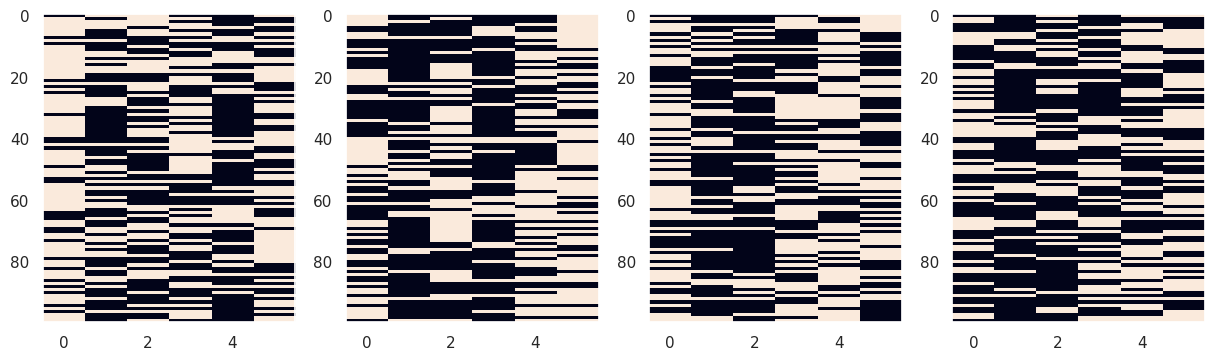

In [14]:
plt.figure(figsize=(15, 4))

for i in range(4):
    plt.subplot(int(str(14)+str(i+1)))
    # Transform data
    key, _key = jr.split(key)
    qz = transform(fitted_model4, X, use_bmr=True, key=_key)
    plt.imshow(qz.mask, aspect='auto')


## 8. PFA with input variables

$$ x_n = W z_n + B u_n + \epsilon_n$$

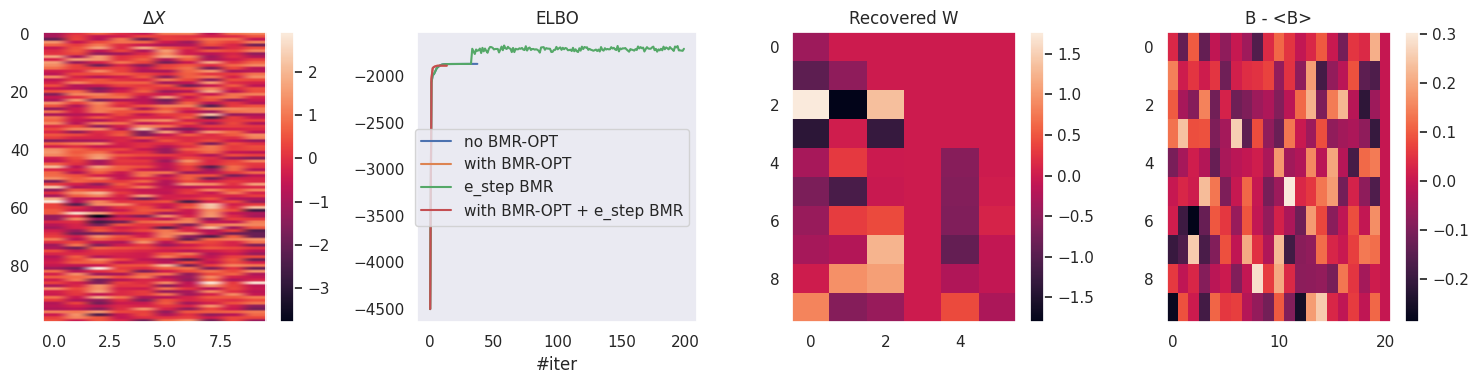

Reconstruction error: 0.836529
ARD posterior [1.54216311 1.9405629  1.3156795  6.55138095 2.40143804 4.96605997]
Posterior noise precision [1.05554312 0.98872438 0.33553497 1.40674081 1.30915319 0.72999155
 1.11658827 0.57656969 1.33442229 0.70968919]


In [6]:
n_input = 20
key, _key = jr.split(key)
U = jr.normal(_key, shape=(n_samples, n_input))

key, _key = jr.split(key)
B = jr.normal(_key, shape=(n_features, n_input)) * 0.1
driven_X = X + U @ B.mT

model1 = PFA(n_components=2 * n_components, n_features=n_features, n_controls=n_input)
model2 = PFA(n_components=2 * n_components, n_features=n_features, n_controls=n_input, optimize_with_bmr=True)
model3 = PFA(n_components=2 * n_components, n_features=n_features, n_controls=n_input, bmr_e_step=True)
model4 = PFA(n_components=2 * n_components, n_features=n_features, n_controls=n_input, optimize_with_bmr=True, bmr_e_step=True)


# Fit model
key, _key = jr.split(key)
fitted_model1, elbos1 = fit(model1, driven_X, _key, U=U, tol=1e-2, n_iter=200)

key, _key = jr.split(key)
fitted_model2, elbos2 = fit(model2, driven_X, _key, U=U, tol=1e-2, n_iter=200)

key, _key = jr.split(key)
fitted_model3, elbos3 = fit(model3, driven_X, _key, U=U, tol=1e-2, n_iter=200)

key, _key = jr.split(key)
fitted_model4, elbos4 = fit(model4, driven_X, _key, U=U, tol=1e-2, n_iter=200)

m = jnp.argmax(jnp.array([elbos1[-1], elbos2[-1], elbos3[-1], elbos4[-1]])).item()
f_model = [fitted_model1, fitted_model2, fitted_model3, fitted_model4][m]  

# Transform data
qz = transform(f_model, driven_X, U=U)

# inverse transform returns a multivariate normal distribution
X_reconstructed = inverse_transform(f_model, qz, U=U).mean

# Visualize results
plt.figure(figsize=(15, 4))

plt.subplot(141)
plt.imshow(driven_X - X_reconstructed, aspect='auto')
plt.title(r'$\Delta X$')
plt.colorbar()

plt.subplot(142)
plt.plot(elbos1, label='no BMR-OPT')
plt.plot(elbos2, label='with BMR-OPT')
plt.plot(elbos3, label='e_step BMR')
plt.plot(elbos4, label='with BMR-OPT + e_step BMR')
plt.title('ELBO')
plt.xlabel('#iter')
plt.legend()

plt.subplot(143)
plt.imshow(f_model.q_w_psi.mvn.mean, aspect='auto')
plt.title('Recovered W')
plt.colorbar()

plt.subplot(144)
plt.imshow(jnp.pad(B, [(0, 0), (0, 1)]) - f_model.control.q_b.mean, aspect='auto')
plt.title('B - <B>')
plt.colorbar()

plt.tight_layout()
plt.show()

# Print reconstruction error
error = jnp.mean((driven_X - X_reconstructed) ** 2)
print(f"Reconstruction error: {error:.6f}")

print("ARD posterior", f_model.q_tau.mean)
print("Posterior noise precision", f_model.q_w_psi.gamma.mean)

[0.83333333 0.5        0.75       0.08333333 0.25       0.08333333]
[0.5 0.5 0.5 0.5 0.5 0.5]
[0.83333333 0.5        0.75       0.08333333 0.16666667 0.08333333]
[0.5 0.5 0.5 0.5 0.5 0.5]


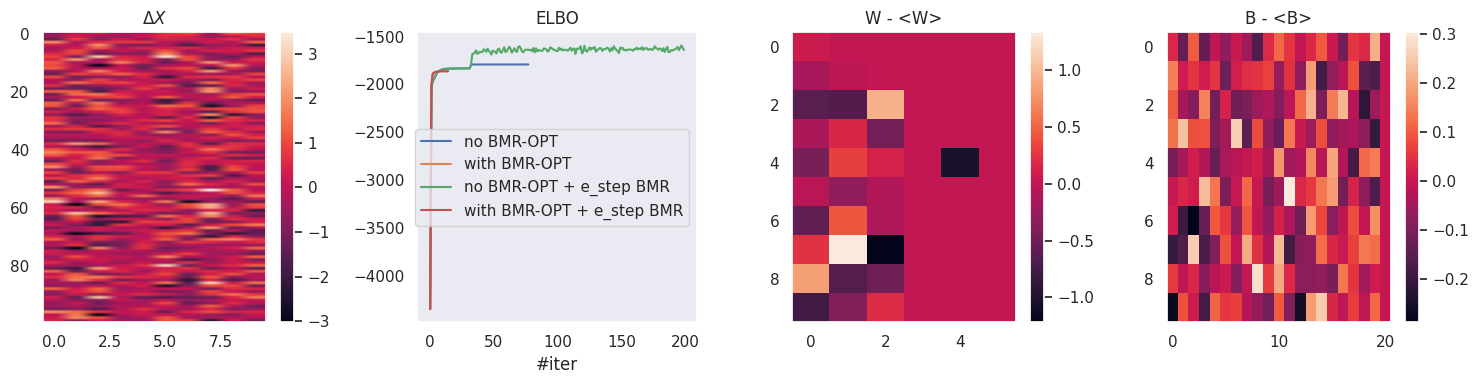

Reconstruction error: 0.902285
ARD posterior [1.01378021 1.05642821 1.23445741 1.         0.50468464 1.        ]
Posterior noise precision [1.13801296 0.86681537 0.45681079 1.32179799 2.7013531  0.93813869
 1.38123652 0.58989023 1.26302837 1.07034369]


In [18]:
model1 = PFA(n_components=2 * n_components, n_features=n_features, n_controls=n_input, bmr_m_step=True)
model2 = PFA(n_components=2 * n_components, n_features=n_features, n_controls=n_input, optimize_with_bmr=True, bmr_m_step=True)
model3 = PFA(n_components=2 * n_components, n_features=n_features, n_controls=n_input, bmr_e_step=True, bmr_m_step=True)
model4 = PFA(n_components=2 * n_components, n_features=n_features, n_controls=n_input, optimize_with_bmr=True, bmr_e_step=True, bmr_m_step=True)

# Fit model
key, _key = jr.split(key)
fitted_model1, elbos1 = fit(model1, X, _key, U=U, tol=1e-2, n_iter=200, bmr_frequency=32)
print(fitted_model1.sparsity_prior.mean)

key, _key = jr.split(key)
fitted_model2, elbos2 = fit(model2, X, _key, U=U, tol=1e-2, n_iter=200, bmr_frequency=32)
print(fitted_model2.sparsity_prior.mean)

key, _key = jr.split(key)
fitted_model3, elbos3 = fit(model3, X, _key, U=U, tol=1e-2, n_iter=200, bmr_frequency=32)
print(fitted_model3.sparsity_prior.mean)

key, _key = jr.split(key)
fitted_model4, elbos4 = fit(model4, X, _key, U=U, tol=1e-2, n_iter=200, bmr_frequency=32)
print(fitted_model4.sparsity_prior.mean)

m = jnp.argmax(jnp.array([elbos1[-1], elbos2[-1], elbos3[-1], elbos4[-1]])).item()
f_model = [fitted_model1, fitted_model2, fitted_model3, fitted_model4][m]

# Transform data
key, _key = jr.split(key)
qz = transform(f_model, X, U=U, use_bmr=True, key=_key)

# inverse transform returns a multivariate normal distribution
X_reconstructed = inverse_transform(f_model, qz, U=U).mean

# Visualize results
plt.figure(figsize=(15, 4))

plt.subplot(141)
plt.imshow(X - X_reconstructed, aspect='auto')
plt.title(r'$\Delta X$')
plt.colorbar()

plt.subplot(142)
plt.plot(elbos1, label='no BMR-OPT')
plt.plot(elbos2, label='with BMR-OPT')
plt.plot(elbos3, label='no BMR-OPT + e_step BMR')
plt.plot(elbos4, label='with BMR-OPT + e_step BMR')
plt.title('ELBO')
plt.xlabel('#iter')
plt.legend()

plt.subplot(143)
plt.imshow(jnp.abs(jnp.pad(W_true.mT, [(0, 0), (0, 3)])) - jnp.abs(f_model.q_w_psi.mean), aspect='auto')
plt.title('W - <W>')
plt.colorbar()

plt.subplot(144)
plt.imshow(jnp.pad(B, [(0, 0), (0, 1)]) - f_model.control.q_b.mean, aspect='auto')
plt.title('B - <B>')
plt.colorbar()

plt.tight_layout()
plt.show()

# Print reconstruction error
error = jnp.mean((X - X_reconstructed) ** 2)
print(f"Reconstruction error: {error:.6f}")

print("ARD posterior", f_model.q_tau.mean)
print("Posterior noise precision", f_model.q_w_psi.gamma.mean)